<h3>Nueral Network Layout</h3>

We will be using a neural network approach to classify. The approach consists of severaal fully connected layers where the first is features, followed by some hidden layers and finally an output layer.
![nn_sample](https://www.qtravel.ai/wp-content/uploads/2023/07/sieci-neuronowe-grafika.png)



<h3>Libraries</h3>
In the following cell, we will import the libraries that are needed for the different parts of the code.

In [29]:
import torch                                           # for creating and training neural networks  
import torch.nn as nn                                  # for creating neural networks
import torch.nn.functional as F                        # for using activation functions 
import matplotlib.pyplot as plt                        # for plotting
import pandas as pd                                    # for dealing with dataframes
import numpy as np                                     # to allow using numpy arrays below
from sklearn.model_selection import train_test_split   # to allow splitting, training and testing
from scipy.stats import ttest_ind                      # to allow t-testing
from sklearn.model_selection import KFold              # to allow k-fold cross validation
from sklearn.metrics import confusion_matrix           # to use confusion matrix
import seaborn as sns                                  # for plotting confusion matrix

<h3>Helper Functions</h3>
In this section, we will define some functions that are going to be used below for different purposes such as filteration, and plotting.

In [39]:
# ------------------------------    Calculating p-values    ------------------------------

def t_test(df, threshold=0.05):
    # Define the flare categories
    group_1 = df[df['Flare'] == 1].drop('Flare', axis=1)  # All samples where flare = 1
    group_3 = df[df['Flare'] == 0].drop('Flare', axis=1)  # All samples where flare = 3

    # Dictionary to store p-values for each gene
    p_values = {}

    # Loop over each gene (column) and perform the statistical test
    for gene in group_1.columns:
        # Extract the gene expression data for each group
        group_1_data = group_1[gene]
        group_3_data = group_3[gene]
        
        # Perform a t-test (you can also use mannwhitneyu for non-parametric test)
        t_stat, p_val = ttest_ind(group_1_data, group_3_data, equal_var=False)  # Welch's t-test
        
        # Store the p-value
        p_values[gene] = p_val

    # Convert the results into a DataFrame for easier visualization
    p_values_df = pd.DataFrame(list(p_values.items()), columns=['Gene', 'P-value'])
    p_values_df = p_values_df.sort_values(by='P-value')
    # Display the p-values
    #print(p_values_df)

    # Drop the ones below 0.05 and save the gene names in a list
    significant_genes = p_values_df[p_values_df['P-value'] < threshold]['Gene'].tolist()
    
    # Debugging lines
    print("T-Test called")
    print("Significant genes length:", len(significant_genes))
    
    return p_values_df, significant_genes

# ------------------------------    Plotting     ------------------------------
def plot_loss(losses, epochs):
    '''
        This function plots the loss rate for each epoch.
        The loss rate is calculated during the training of the neural network.
    '''
    plt.plot(range(epochs),losses)
    plt.ylabel("Loss Rate")
    plt.xlabel("Epoch")

# ------------------------------    Filtering Genes     ------------------------------
def filter_genes(p_values_df, threshold=0.05):
    '''
        This function filters the genes based on the p-values.
        The genes with p-values below the threshold are selected.
        The function returns the filtered genes.
    '''
    #print("function called")
    significant_genes = p_values_df[p_values_df['P-value'] < threshold]['Gene'].tolist()
    return significant_genes

# ------------------------------    Old Filtering Function     ------------------------------
def selected_sample(filtering_set, original_data, number_of_ids):
    selected_IDs = filtering_set["GeneID"][0:number_of_ids].tolist()
    selected_IDs.append("Flare")
    return original_data[selected_IDs] 


# ------------------------------    Cross Validation    ------------------------------

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold

def cross_validation(data, epochs, batch_size=10, learning_rate=2e-4, threshold=0.05, k=5, patience=100):
    '''
    This function performs the cross-validation
    for the neural network model with early stopping.
    '''
    # Set the random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # confusion matrix calculation.
    cumulative_cm = np.zeros((2, 2), dtype=int)

    # Split the data into features and labels
    X = data.drop('Flare', axis=1).values
    y = data['Flare'].values    

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Define the list to store the accuracies
    accuracies = []

    # Loop over each fold
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create a dataframe that has X_train and y_train
        train_data = pd.DataFrame(X_train)
        train_data["Flare"] = y_train

        # Perform the t-test to get the p-values
        p_values_df, significant_genes = t_test(train_data, threshold)

        # Filter the genes based on the p-values
        X_train = train_data[significant_genes].values
        X_val = pd.DataFrame(X_val)[significant_genes].values

        # Convert the data into PyTorch tensors
        X_train = torch.FloatTensor(X_train)
        X_val = torch.FloatTensor(X_val)
        y_train = torch.LongTensor(y_train)
        y_val = torch.LongTensor(y_val)

        # Create a model
        model = Model(in_features=X_train.shape[1])

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Early stopping variables
        best_loss = float('inf')
        patience_counter = 0

        # Lists to store loss values
        train_losses = []
        val_losses = []

        # Train the model
        model.train()
        early_stopped_epoch = -1  # To keep track of when early stopping happens
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            # Store the training loss
            train_losses.append(loss.item())

            # Validate the model
            model.eval()
            with torch.no_grad():
                y_pred_val = model(X_val)
                val_loss = criterion(y_pred_val, y_val)
                val_losses.append(val_loss.item())

            # Check for early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                early_stopped_epoch = epoch  # Record the epoch where early stopping occurred
                break

        # If early stopping occurred, simulate the remaining epochs for plotting
        if early_stopped_epoch != -1:
            # Pad the losses with the last loss value to simulate continuation for the plot
            train_losses.extend([train_losses[-1]] * (epochs - early_stopped_epoch - 1))
            val_losses.extend([val_losses[-1]] * (epochs - early_stopped_epoch - 1))

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
            correct = (y_pred.argmax(1) == y_val).type(torch.float).sum().item()
            accuracy = correct / len(y_val)
            accuracies.append(accuracy)
            # Show the accuracy for each fold
            print(f'Fold {fold + 1}/{k} Accuracy: {accuracy}')
            # Adding cm
            cm = confusion_matrix(y_val.numpy(), y_pred.argmax(1).numpy())
            cumulative_cm += cm
        # Plot the training and validation loss
        plt.figure()
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')

        # Show a vertical line at the early stopping point if it occurred
        if early_stopped_epoch != -1:
            plt.axvline(x=early_stopped_epoch, color='r', linestyle='--', label=f'Early Stopping at Epoch {early_stopped_epoch + 1}')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.legend()
        plt.show()

    # Calculate the average accuracy
    average_accuracy = sum(accuracies) / k

    return average_accuracy, cumulative_cm
    

<h3>Defining the Neural Network Model</h3>
In the following section we will define the NN model to be used for training.

In [40]:
#number_of_features = 1250
number_of_neurons = 512
class Model(nn.Module):
    ''' Creating input layers that will have the features of the data.
    This will be sent to hidden layers to learn and finally this will 
    produce the classification as the output.'''
    number_of_outcomes = 2  # Possible outcomes

    
    def __init__(self, in_features, h1=2048, h2=2048, h3=2048, h4=1024, h5=512, h6=256, h7=128, h8=64, out_features=number_of_outcomes):
        # Calling the constructor of the superclass to instantiate nn.Module
        super().__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.fc6 = nn.Linear(h5, h6)
        self.fc7 = nn.Linear(h6, h7)
        self.fc8 = nn.Linear(h7, h8)
        self.out = nn.Linear(h8, out_features)

    # Function that moves everything forward in the layers
    def forward(self, x):
        # Rectified linear unit function that will only use positive output and set negatives to zero
        x = F.relu(self.fc1(x))  # Starting with layer 1
        x = F.relu(self.fc2(x))  # Moving to layer 2
        x = F.relu(self.fc3(x))  # Moving to layer 3
        x = F.relu(self.fc4(x))  # Moving to layer 4
        x = F.relu(self.fc5(x))  # Moving to layer 5
        x = F.relu(self.fc6(x))  # Moving to layer 6
        x = F.relu(self.fc7(x))  # Moving to layer 7
        x = F.relu(self.fc8(x))  # Moving to layer 8
        x = self.out(x)
        return x  # Returning the output

<h3>Loading and Preparing the Data</h3>
In the following cell, we will load the data to be used for training the model. In this case, it is the filtered flare data in which only week 48 samples are selected. The data is also cleaned to remove any genes with constant expression number and/or very low expression number. The next step is to make sure the data is ready to be used for the prediction.


In [41]:
all_data = pd.read_csv('../Data/processed_data.csv')

# replace Flare 3 with 0 to make it binary classification
all_data['Flare'] = all_data['Flare'].replace(3, 0)

<h3>Running the Model</h3>
Next, we will run the model using the functions defined above.

T-Test called
Significant genes length: 741
Early stopping at epoch 137
Fold 1/10 Accuracy: 0.6111111111111112


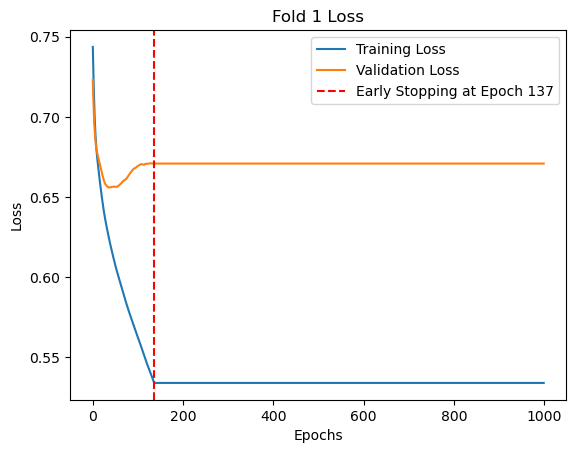

T-Test called
Significant genes length: 753
Early stopping at epoch 145
Fold 2/10 Accuracy: 0.6111111111111112


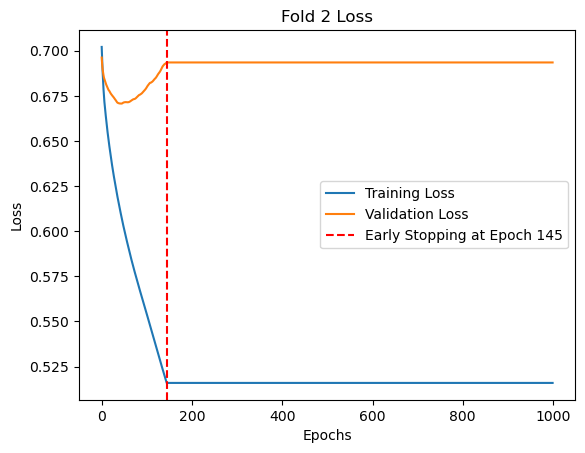

T-Test called
Significant genes length: 886
Early stopping at epoch 137
Fold 3/10 Accuracy: 0.3888888888888889


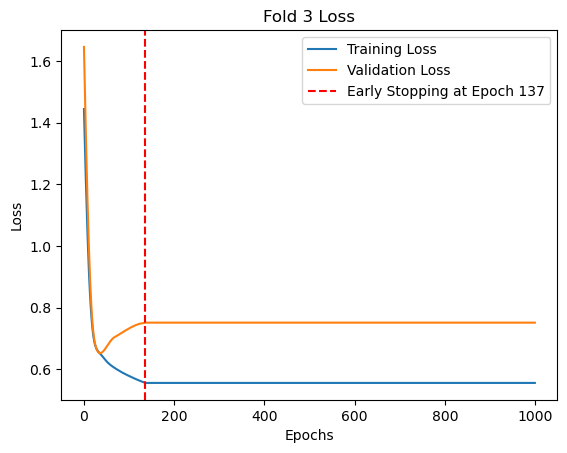

T-Test called
Significant genes length: 606
Early stopping at epoch 174
Fold 4/10 Accuracy: 0.6111111111111112


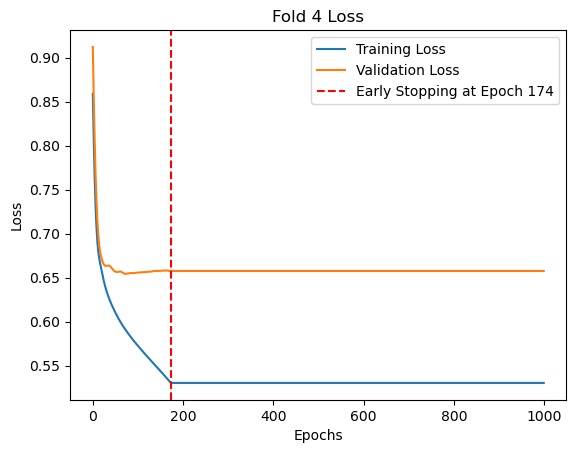

T-Test called
Significant genes length: 986
Early stopping at epoch 128
Fold 5/10 Accuracy: 0.6470588235294118


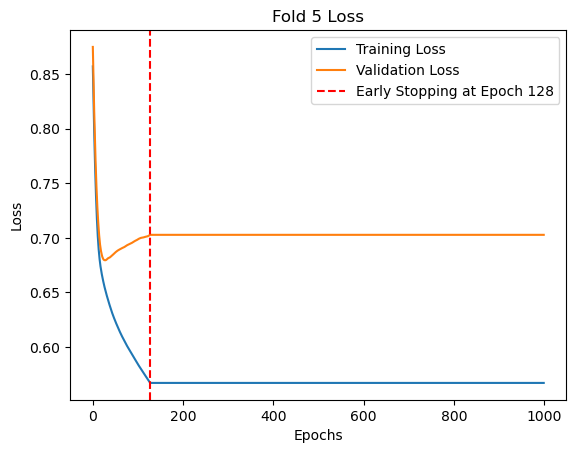

T-Test called
Significant genes length: 771
Early stopping at epoch 864
Fold 6/10 Accuracy: 0.7647058823529411


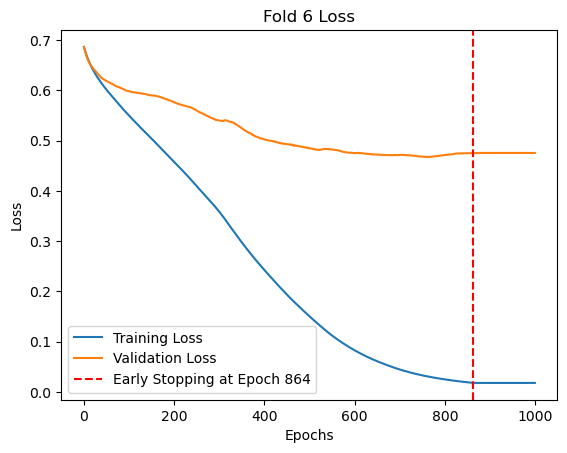

T-Test called
Significant genes length: 607
Early stopping at epoch 420
Fold 7/10 Accuracy: 0.7058823529411765


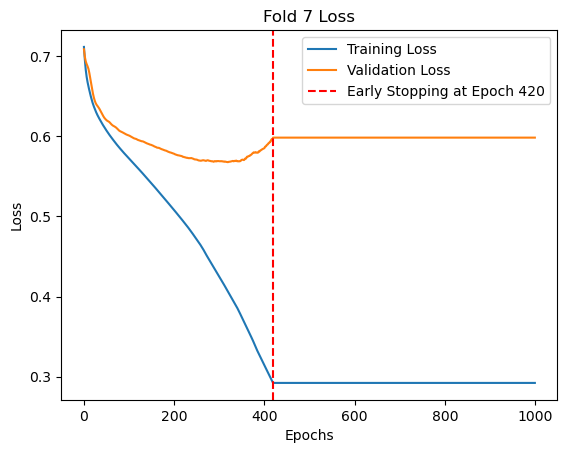

T-Test called
Significant genes length: 813
Early stopping at epoch 257
Fold 8/10 Accuracy: 0.6470588235294118


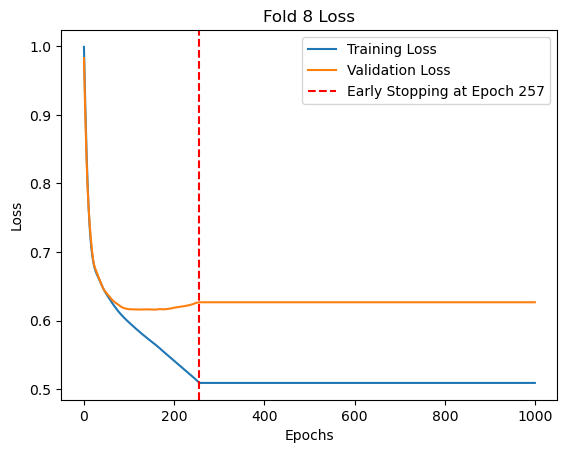

T-Test called
Significant genes length: 996
Early stopping at epoch 103
Fold 9/10 Accuracy: 0.7647058823529411


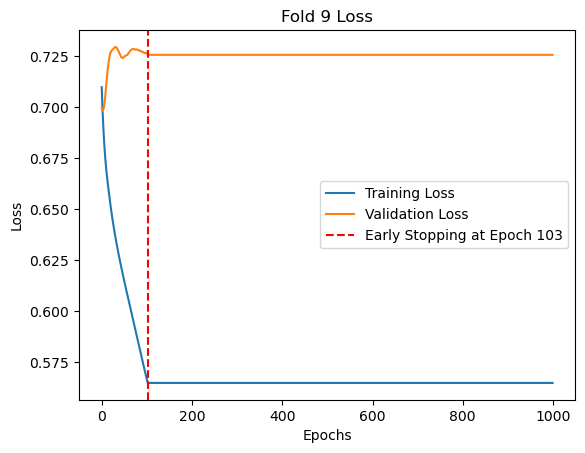

T-Test called
Significant genes length: 706
Early stopping at epoch 226
Fold 10/10 Accuracy: 0.5882352941176471


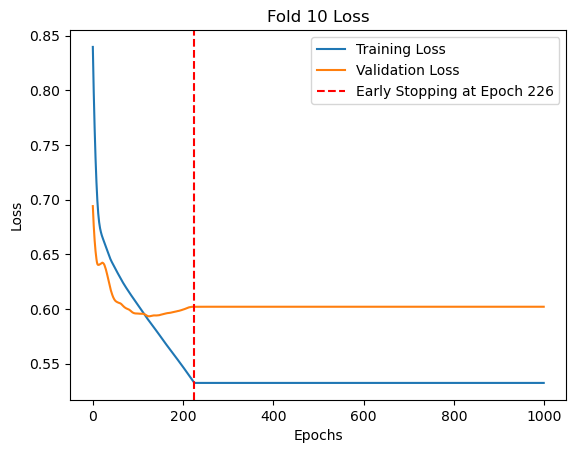

Average accuracy: 0.6339869281045752


In [42]:
# create a model
#model = Model()

# define the number of epochs
epochs = 1000 # was 3500

# define the batch size
batch_size = 32 # 10

# define the learning rate
learning_rate = 1e-6 # was 2e-4

# define the threshold for the p-values
threshold = 0.05 # was 0.05

# define the number of folds for cross-validation
k = 10 # was 10

# define the patience for early stopping
patience= 50 # was 100

# Perform cross-validation
average_accuracy, cumulative_cm = cross_validation(all_data, epochs, batch_size, learning_rate, threshold, k)
print(f'Average accuracy: {average_accuracy}')


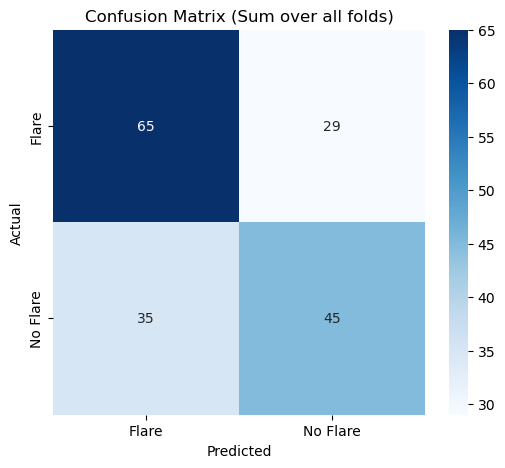

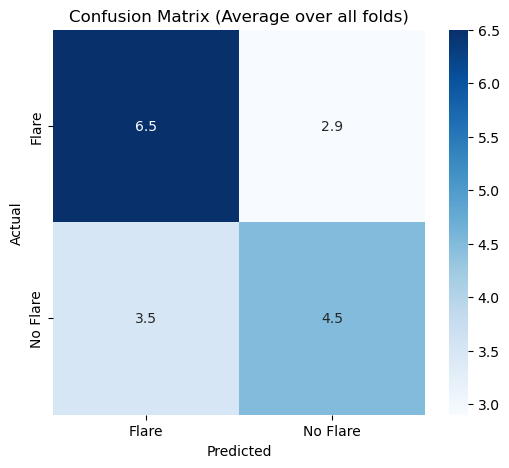

/var/folders/60/jkn0_02s1lv9xfxqt4gzj2lw0000gn/T/ipykernel_62525/2251438603.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=colors)


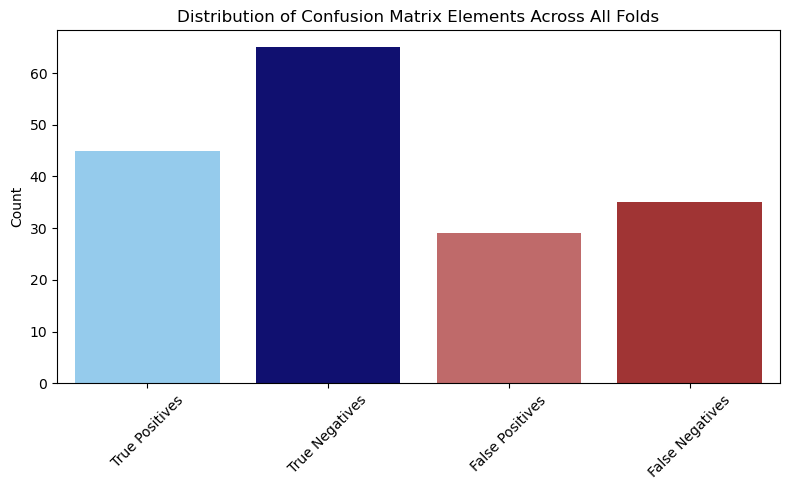

In [60]:



# Calculate average confusion matrix
average_cm = cumulative_cm / k
tn, fp, fn, tp = cumulative_cm.ravel()

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cumulative_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Flare", "No Flare"], yticklabels=["Flare", "No Flare"])
plt.title("Confusion Matrix (Sum over all folds)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#plot average matirx
plt.figure(figsize=(6, 5))
sns.heatmap(average_cm, annot=True, cmap='Blues', xticklabels=["Flare", "No Flare"], yticklabels=["Flare", "No Flare"])
plt.title("Confusion Matrix (Average over all folds)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Plot bar chart of TP, FP, FN, TN
labels = ['True Positives', 'True Negatives', 'False Positives',  'False Negatives']
values = [tp, tn , fp , fn]
colors = ['lightskyblue', 'navy', 'indianred', 'firebrick']

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=values, palette=colors)
plt.title("Distribution of Confusion Matrix Elements Across All Folds")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



